In [56]:
# IMPORT REQUIRED LIBRARIES

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os, warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.feature_selection import SelectKBest, f_regression
# Try XGBoost
try:
    from xgboost import XGBRegressor
    has_xgb = True
except Exception:
    has_xgb = False

OUT = "./mobile_price_output"
os.makedirs(OUT, exist_ok=True)

import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully.")

Libraries imported successfully.


In [2]:
# LOAD THE DATASET

df = pd.read_csv("Mobile_Data.csv")
print("✅ Dataset loaded successfully.")
print(f"Dataset Shape: {df.shape}")

# Preview first 5 few rows
display(df.head())

✅ Dataset loaded successfully.
Dataset Shape: (541, 11)


,Model,Colour,Memory,RAM,Battery_Hz,Rear Camera,Front Camera,AI Lens,Mobile Height,Processor_,Price
0,Infinix SMART 7,Night Black,64,4,6000,13MP,5MP,1,16.76,Unisoc Spreadtrum SC9863A1,7299
1,Infinix SMART 7,Azure Blue,64,4,6000,13MP,5MP,1,16.76,Unisoc Spreadtrum SC9863A1,7299
2,MOTOROLA G32,Mineral Gray,128,8,5000,50MP,16MP,0,16.64,Qualcomm Snapdragon 680,11999
3,POCO C50,Royal Blue,32,2,5000,8MP,5MP,0,16.56,Mediatek Helio A22,5649
4,Infinix HOT 30i,Marigold,128,8,5000,50MP,5MP,1,16.76,G37,8999


In [3]:
# Detect target column
candidates = [c for c in df.columns if any(k in c.lower() for k in ("price","prize","cost","amount","selling"))]
if candidates:
    target_col = candidates[0]
else:
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    target_col = df[numeric_cols].var().sort_values(ascending=False).index[0]

print("Detected target column:", target_col)

Detected target column: Price


In [4]:
# CLEAN TARGET COLUMN (REMOVE COMMAS, SYMBOLS, SPACE ETC)

def clean_numeric_series(s):
    s = s.astype(str).str.replace(r'[^\d\.-]', '', regex=True)
    return pd.to_numeric(s, errors='coerce')

df[target_col] = clean_numeric_series(df[target_col])

# Try fallback 'Prize' if price mostly NaN
if df[target_col].isnull().sum() > len(df)*0.5 and "Prize" in df.columns:
    df["Prize"] = clean_numeric_series(df["Prize"])
    if df["Prize"].notnull().sum() > df[target_col].notnull().sum():
        target_col = "Prize"
        print("Switched target to Prize")

df = df[df[target_col].notnull()].reset_index(drop=True)
print("Final target column:", target_col)
print(df[target_col].describe())

Final target column: Price
count      541.000000
mean     16228.375231
std      10793.588322
min        920.000000
25%       9290.000000
50%      13499.000000
75%      19280.000000
max      80999.000000
Name: Price, dtype: float64


In [6]:
# EXPLORATORY DATA ANALYSIS (EDA) : Basic Info & Summary

print("Dataset Information:\n")
print(df.info())
print("\nStatistical Summary (Numeric Features):\n")
display(df.describe())

Dataset Information:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541 entries, 0 to 540
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Model          541 non-null    object 
 1   Colour         541 non-null    object 
 2   Memory         541 non-null    int64  
 3   RAM            541 non-null    int64  
 4   Battery_Hz     541 non-null    int64  
 5   Rear Camera    541 non-null    object 
 6   Front Camera   541 non-null    object 
 7   AI Lens        541 non-null    int64  
 8   Mobile Height  541 non-null    float64
 9   Processor_     541 non-null    object 
 10  Price          541 non-null    int64  
dtypes: float64(1), int64(5), object(5)
memory usage: 46.6+ KB
None

Statistical Summary (Numeric Features):



,Memory,RAM,Battery_Hz,AI Lens,Mobile Height,Price
count,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000
mean,110.550832,5.397412,4871.587800,0.062847,16.431201,16228.375231
std,60.600694,1.984923,780.148862,0.242911,2.523553,10793.588322
min,16.000000,2.000000,800.000000,0.000000,4.500000,920.000000
25%,64.000000,4.000000,5000.000000,0.000000,16.510000,9290.000000
50%,128.000000,6.000000,5000.000000,0.000000,16.710000,13499.000000
75%,128.000000,8.000000,5000.000000,0.000000,16.940000,19280.000000
max,256.000000,8.000000,7000.000000,1.000000,41.940000,80999.000000


In [8]:
# Missing Values Detection:- 

missing = df.isnull().sum().sort_values(ascending=False)
missing = missing[missing > 0]
if len(missing) > 0:
    print("\nMissing Values Detected:\n")
    print(missing)
    plt.figure(figsize=(10,5))
    sns.barplot(x=missing.index, y=missing.values, color='tomato')
    plt.xticks(rotation=90)
    plt.title("Missing Values per Feature")
    plt.xlabel("Features")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()
else:
    print("\nNo missing values detected.\n")


No missing values detected.



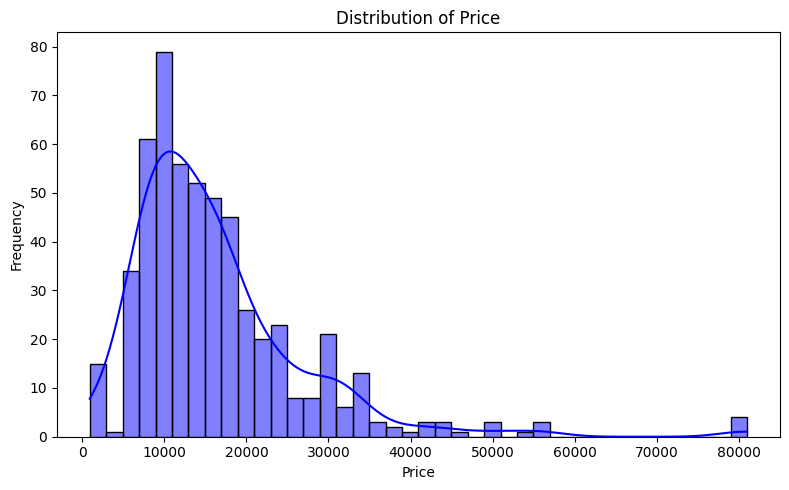

Skewness of Price: 2.43
Strong Right Skew (few expensive phones dominate)


In [19]:
#Target Variable Distribution

plt.figure(figsize=(8,5))
sns.histplot(df[target_col], kde=True, bins=40, color='blue')
plt.title(f"Distribution of {target_col}")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

#  And Check skewness
skew_val = df[target_col].skew()
print(f"Skewness of {target_col}: {skew_val:.2f}")
if skew_val > 1:
    print("Strong Right Skew (few expensive phones dominate)")
elif skew_val < -1:
    print("Left Skew")
else:
    print("Fairly Normal Distribution")

<Figure size 1000x900 with 0 Axes>

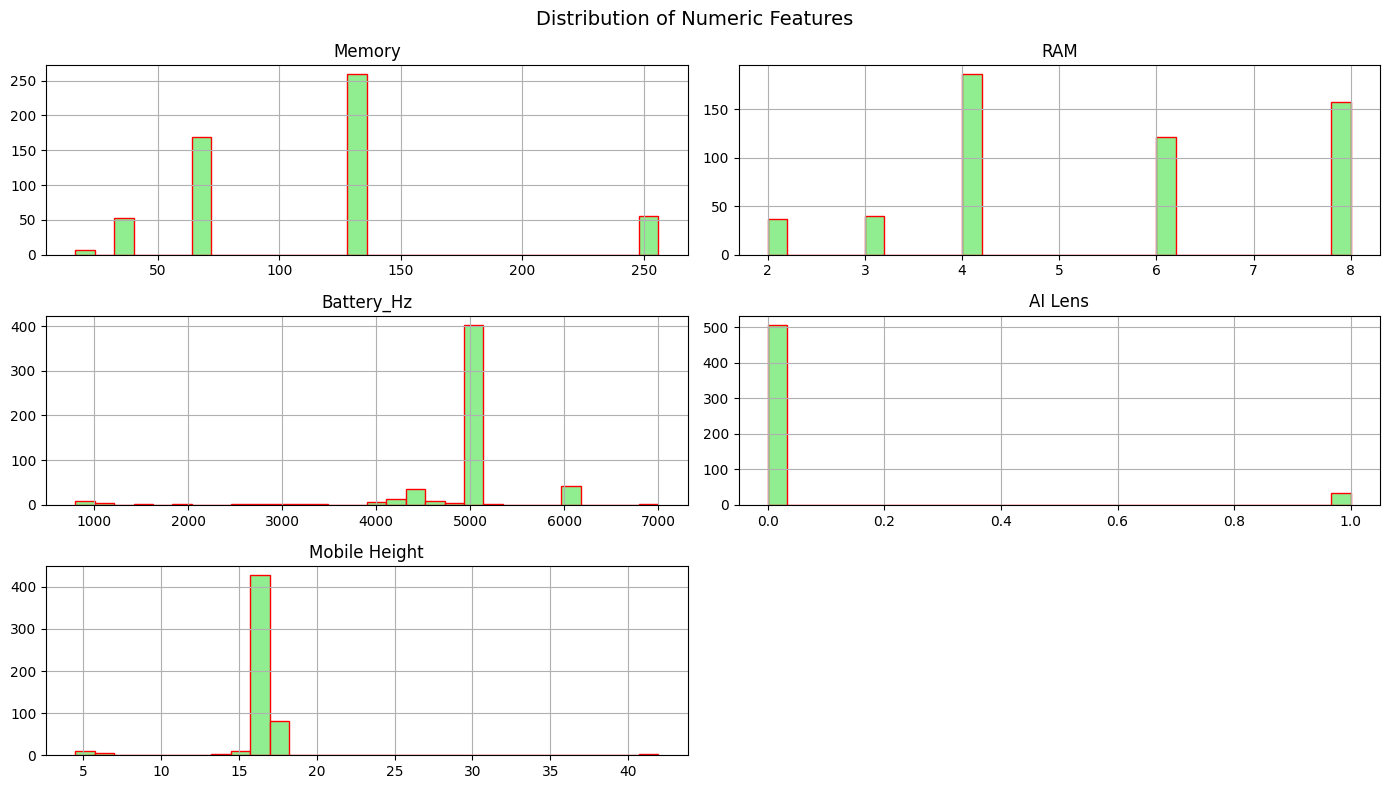

In [26]:
# Univariate Analysis — Numeric Features

numeric_features = df.select_dtypes(include=[np.number]).columns.tolist()
numeric_features = [c for c in numeric_features if c != target_col]

if len(numeric_features) > 0:
    plt.figure(figsize=(10, 9))
    df[numeric_features].hist(bins=30, figsize=(14, 8), color='lightgreen', edgecolor='red')
    plt.suptitle("Distribution of Numeric Features", fontsize=14)
    plt.tight_layout()
    plt.show()

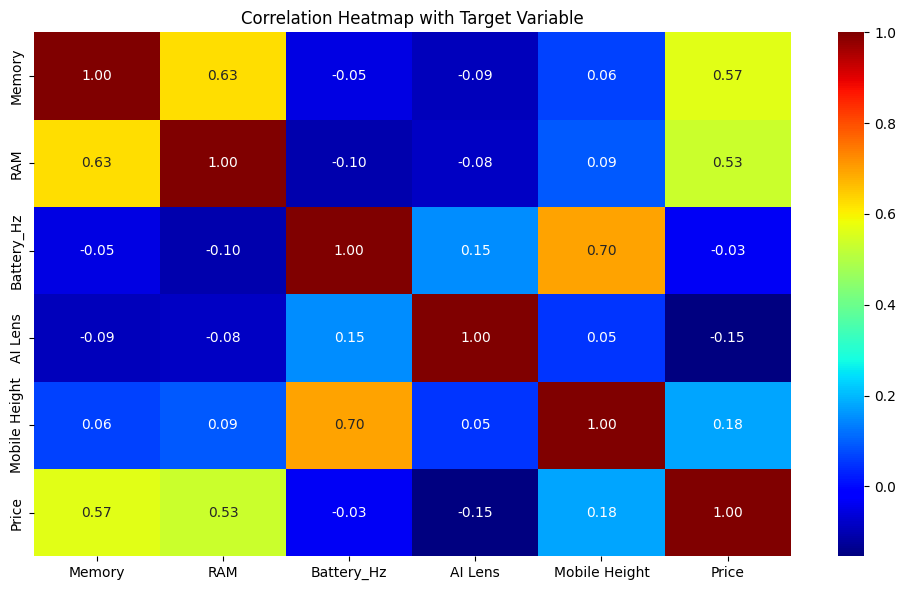


Top Correlations with Target:

Price            1.000000
Memory           0.566660
RAM              0.532024
Mobile Height    0.176009
Battery_Hz      -0.034297
AI Lens         -0.153691
Name: Price, dtype: float64


In [29]:
# Correlation Heatmap (Top Numeric Features)

if len(numeric_features) > 1:
    plt.figure(figsize=(10,6))
    corr = df[numeric_features + [target_col]].corr()
    sns.heatmap(corr, annot=True, cmap='jet', fmt=".2f")
    plt.title("Correlation Heatmap with Target Variable")
    plt.tight_layout()
    plt.show()

    print("\nTop Correlations with Target:\n")
    print(corr[target_col].sort_values(ascending=False).head(10))

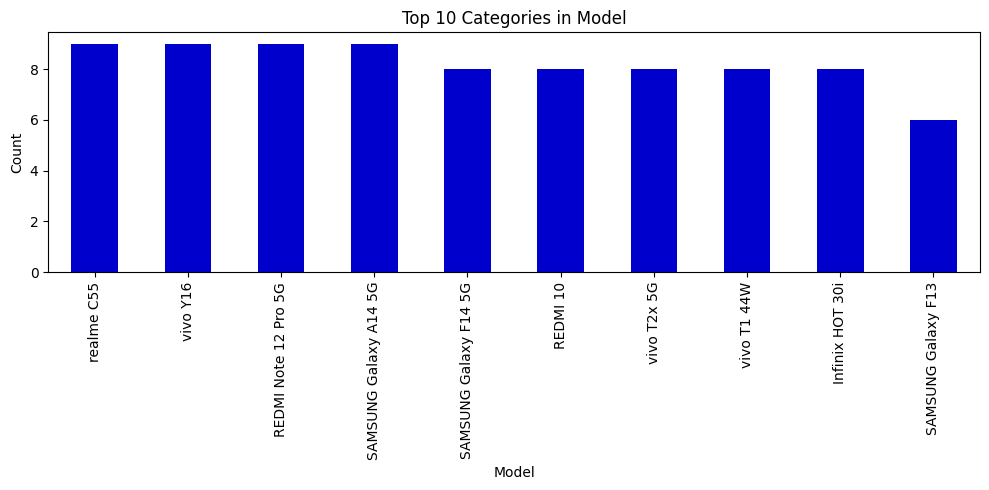

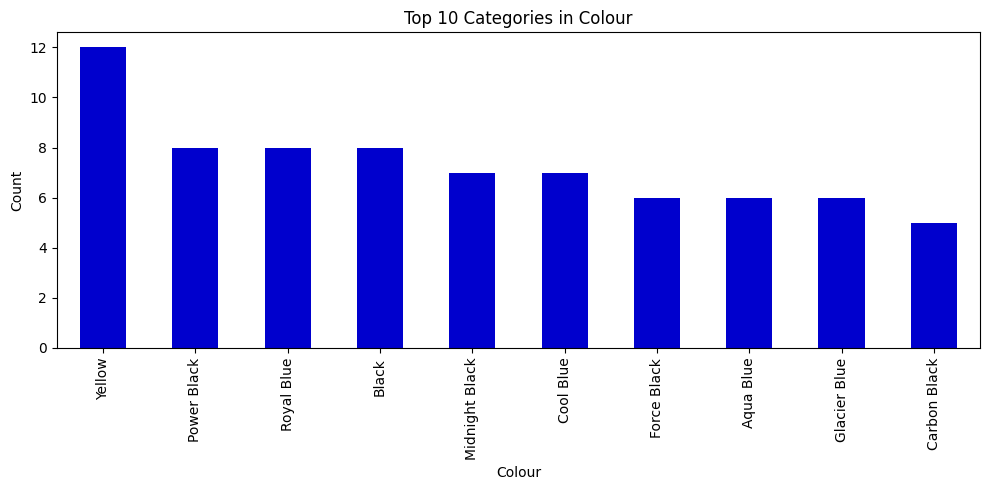

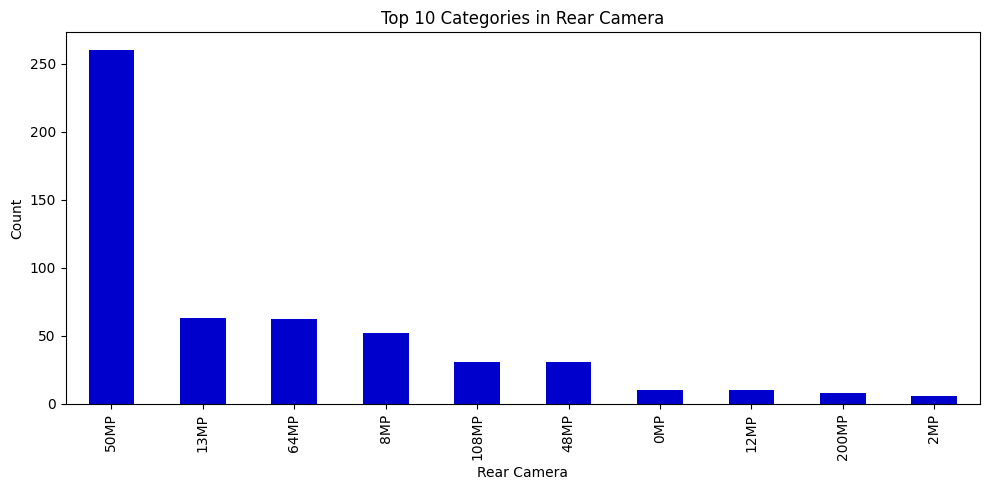

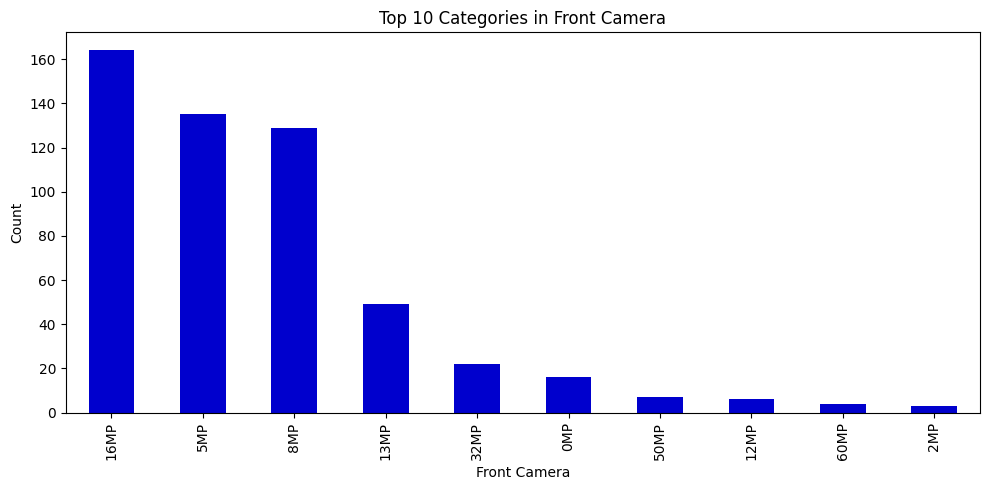

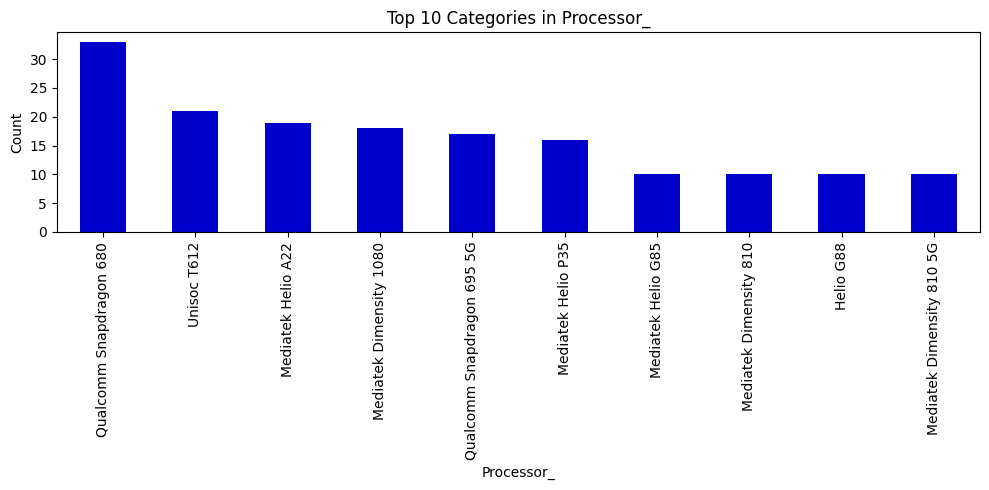

In [35]:
# Categorical Feature Distribution

categorical_features = df.select_dtypes(include=['object', 'category']).columns.tolist()
if len(categorical_features) > 0:
    for col in categorical_features[:5]:  # Show top 5 to avoid overload
        plt.figure(figsize=(10,5))
        df[col].value_counts().head(10).plot(kind='bar', color='mediumblue')
        plt.title(f"Top 10 Categories in {col}")
        plt.ylabel("Count")
        plt.tight_layout()
        plt.show()

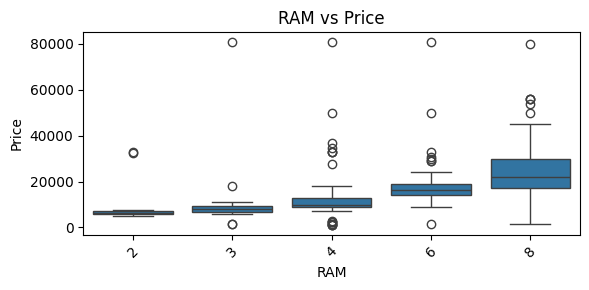

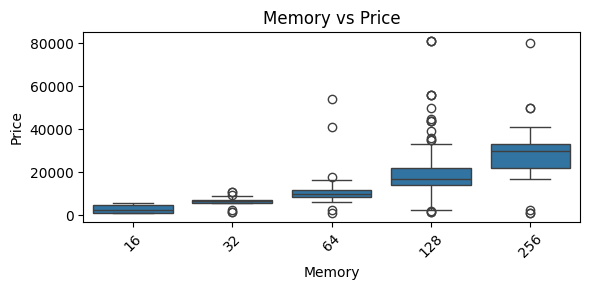

In [40]:
# Relationship between Key Features and Target

potential_features = ['RAM', 'Battery', 'Memory', 'Display', 'Storage', 'Rating', 'Camera']
for col in potential_features:
    if col in df.columns:
        plt.figure(figsize=(6,3))
        sns.boxplot(x=col, y=target_col, data=df)
        plt.title(f"{col} vs {target_col}")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

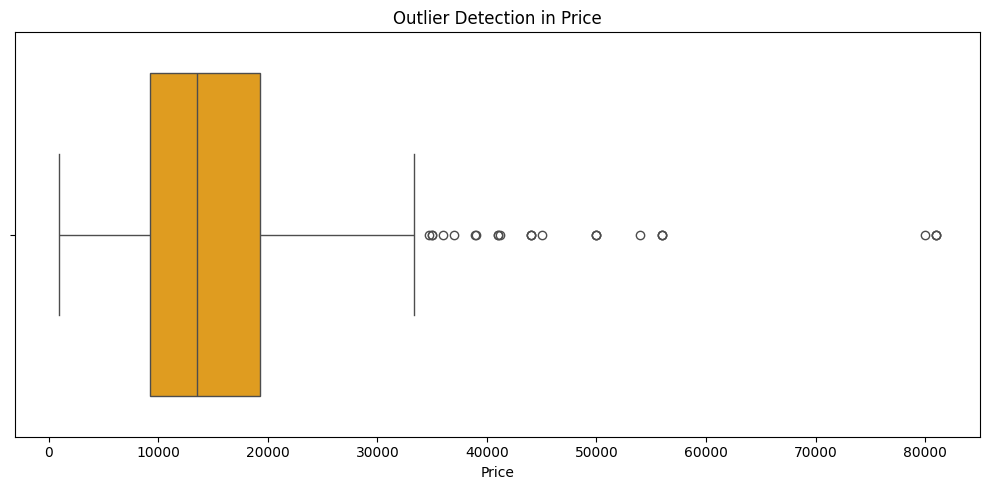

In [42]:
# Outlier Detection

plt.figure(figsize=(10,5))
sns.boxplot(x=df[target_col], color='orange')
plt.title(f"Outlier Detection in {target_col}")
plt.xlabel("Price")
plt.tight_layout()
plt.show()

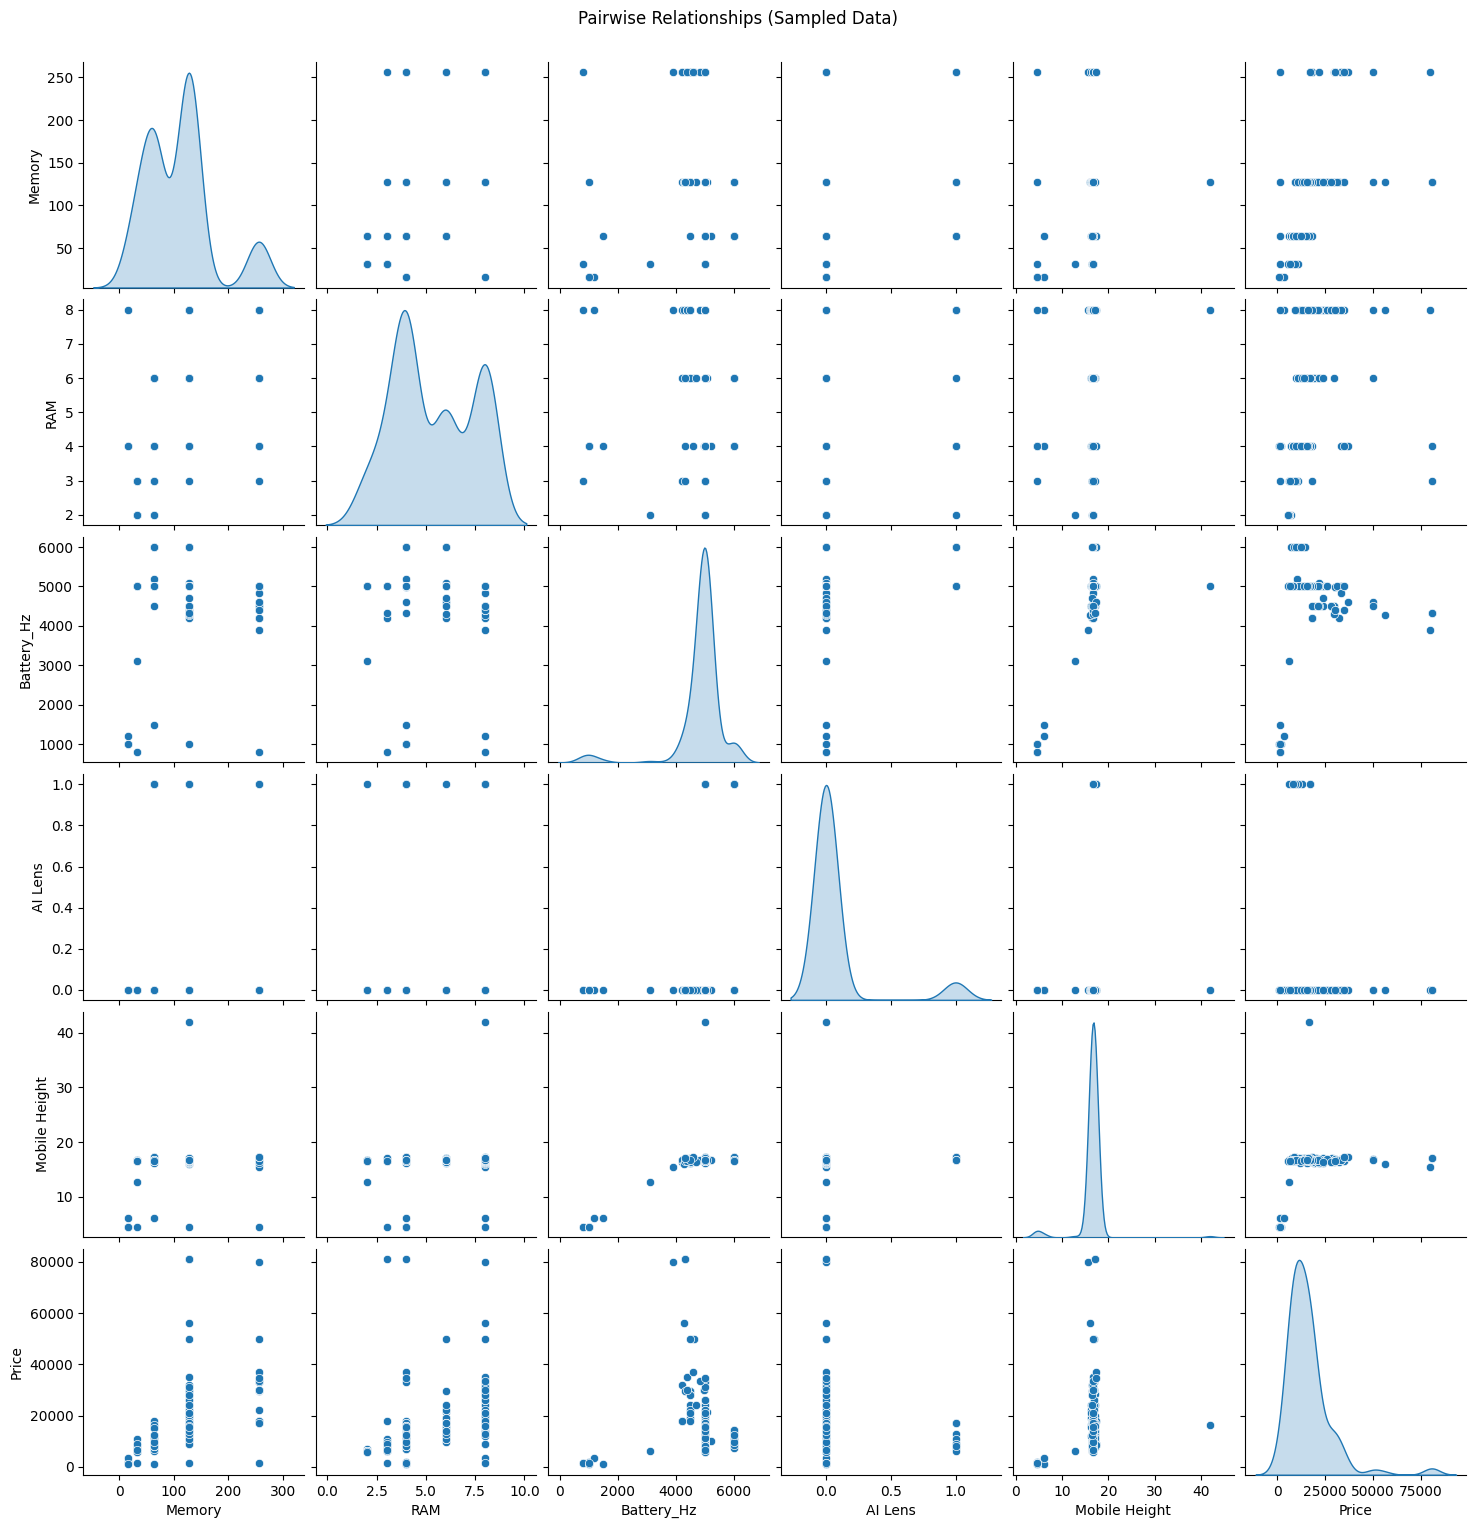


EDA Completed Successfully!


In [43]:
# Feature Relationships (Pairplot)

if len(numeric_features) >= 3:
    sampled = df.sample(min(200, len(df)), random_state=42)
    sns.pairplot(sampled[numeric_features + [target_col]], diag_kind='kde')
    plt.suptitle("Pairwise Relationships (Sampled Data)", y=1.02)
    plt.show()

print("\nEDA Completed Successfully!")

In [45]:
# FEATURE PREPARATION

X = df.drop(columns=[target_col]).copy()
y = df[target_col].copy()

# Convert object columns to string
for c in X.select_dtypes(include=['object','category']).columns:
    X[c] = X[c].astype(str)

# Extract numeric values from text columns such as RAM, Battery, Memory
def extract_first_num(col):
    return col.astype(str).str.extract(r'(\d+)').iloc[:,0].astype(float)

for c in ['RAM','ram','Memory','InternalMemory','Battery_Hz','battery','ROM']:
    if c in X.columns and not pd.api.types.is_numeric_dtype(X[c]):
        X[c+"_num"] = extract_first_num(X[c])

num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X.select_dtypes(include=['object','category']).columns.tolist()
print(f"Numeric cols: {len(num_cols)}, Categorical cols: {len(cat_cols)}")

Numeric cols: 5, Categorical cols: 5


In [57]:
# FEATURE SELECTION USING SELECTKBEST

num_for_select = X[num_cols].fillna(X[num_cols].median())
skb = SelectKBest(score_func=f_regression, k=min(10, len(num_for_select.columns)))
skb.fit(num_for_select, y)
scores = pd.Series(skb.scores_, index=num_for_select.columns).sort_values(ascending=False)
print("\nTop numeric features by correlation with target:")
print(scores.head(10))
scores.to_csv(os.path.join(OUT, "selectk_scores.csv"))


Top numeric features by correlation with target:
Memory           254.935168
RAM              212.795810
Mobile Height     17.231581
AI Lens           13.039714
Battery_Hz         0.634769
dtype: float64


In [58]:
# PREPROCESSING PIPELINE

numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="constant", fill_value="Missing")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocessor = ColumnTransformer([
    ("num", numeric_transformer, num_cols),
    ("cat", categorical_transformer, cat_cols)
], remainder="drop")

print("Preprocessing pipeline created successfully!")

Preprocessing pipeline created successfully!


In [59]:
# TRAIN-TEST SPLIT

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

Train shape: (432, 10) Test shape: (109, 10)


In [60]:
# TRAIN MULTIPLE MODELS & COMPARE RESULTS

models = {
    "Linear Regression": LinearRegression(),
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=0.001),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=200, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "KNN": KNeighborsRegressor(n_neighbors=5),
    "SVR": SVR()
}

if has_xgb:
    models["XGBoost"] = XGBRegressor(n_estimators=300, learning_rate=0.05, random_state=42)

results = []
print("Training models... This may take a few minutes.\n")

for name, model in models.items():
    pipe = Pipeline([("preprocessor", preprocessor), ("model", model)])
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)
    
    try:
        rmse = mean_squared_error(y_test, preds, squared=False)
    except TypeError:
        rmse = np.sqrt(mean_squared_error(y_test, preds))
    
    mae = mean_absolute_error(y_test, preds)
    r2 = r2_score(y_test, preds)
    
    results.append({"Model": name, "R2": r2, "RMSE": rmse, "MAE": mae})
    print(f"{name:20s} | R2={r2:.4f} | RMSE={rmse:.2f} | MAE={mae:.2f}")

results_df = pd.DataFrame(results).sort_values(by="R2", ascending=False)
print("\nModel Comparison Table:")
display(results_df)

Training models... This may take a few minutes.

Linear Regression    | R2=0.8374 | RMSE=4733.71 | MAE=1810.26
Ridge                | R2=0.8252 | RMSE=4908.12 | MAE=2020.77
Lasso                | R2=0.7143 | RMSE=6275.48 | MAE=1758.52
Decision Tree        | R2=0.7237 | RMSE=6171.00 | MAE=1281.30
Random Forest        | R2=0.8331 | RMSE=4795.88 | MAE=1797.70
Gradient Boosting    | R2=0.8484 | RMSE=4571.16 | MAE=2349.06
KNN                  | R2=0.6908 | RMSE=6527.93 | MAE=2478.33
SVR                  | R2=-0.0178 | RMSE=11843.90 | MAE=6963.81

Model Comparison Table:


,Model,R2,RMSE,MAE
5,Gradient Boosting,0.848394,4571.156348,2349.057411
0,Linear Regression,0.837420,4733.708481,1810.261501
4,Random Forest,0.833122,4795.875232,1797.704436
1,Ridge,0.825219,4908.124710,2020.774371
3,Decision Tree,0.723705,6170.996360,1281.302752
2,Lasso,0.714269,6275.479127,1758.523800
6,KNN,0.690818,6527.931251,2478.326606
7,SVR,-0.017778,11843.904627,6963.808096


Extracting feature importances from: Gradient Boosting


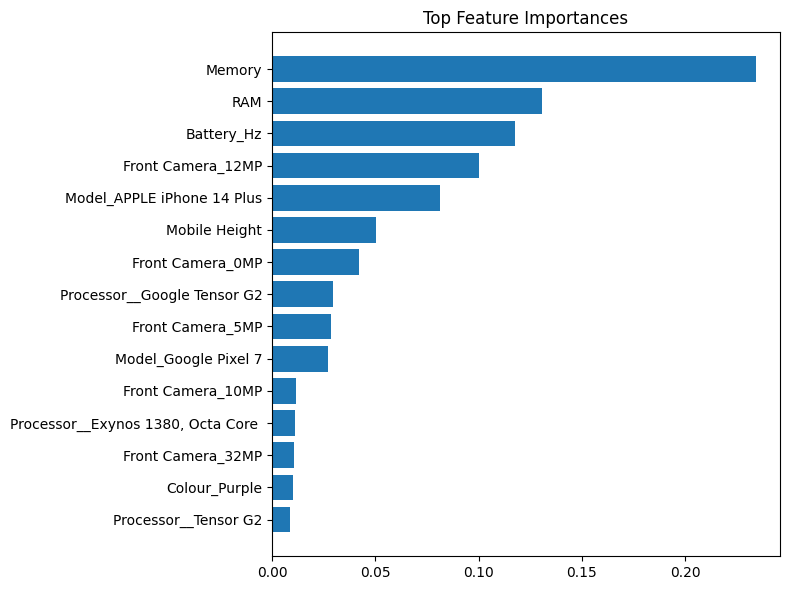

In [61]:
# FEATURE IMPORTANCE FROM BEST TREE MODEL

best_model = None
for m in ["Gradient Boosting","Random Forest","Decision Tree","XGBoost"]:
    if any(m.lower().replace(" ","") in x.lower().replace(" ","") for x in results_df["Model"]):
        best_model = m
        break

if best_model:
    print("Extracting feature importances from:", best_model)
    reg = models[best_model] if best_model in models else None
    preprocessor.fit(X_train)
    cat_names = []
    try:
        cat_names = preprocessor.named_transformers_["cat"].named_steps["onehot"].get_feature_names_out(cat_cols).tolist()
    except Exception:
        cat_names = cat_cols
    feature_names = num_cols + cat_names
    importances = reg.feature_importances_ if hasattr(reg, "feature_importances_") else None
    if importances is not None:
        fi = pd.DataFrame({"feature": feature_names, "importance": importances}).sort_values(by="importance", ascending=False)
        plt.figure(figsize=(8,6))
        plt.barh(fi.head(15)["feature"][::-1], fi.head(15)["importance"][::-1])
        plt.title("Top Feature Importances")
        plt.tight_layout()
        plt.savefig(os.path.join(OUT,"feature_importance.png"))
        plt.show()
        fi.to_csv(os.path.join(OUT,"feature_importances.csv"), index=False)

In [62]:
# SAVE PROCESSED SAMPLE FEATURES

preprocessor.fit(X_train)
X_proc = preprocessor.transform(X_train.head(50))
proc_feature_names = []
for nm, trans, cols in preprocessor.transformers_:
    if nm == "num": proc_feature_names += list(cols)
    elif nm == "cat":
        try:
            proc_feature_names += trans.named_steps["onehot"].get_feature_names_out(cols).tolist()
        except Exception:
            proc_feature_names += list(cols)
proc_df = pd.DataFrame(X_proc, columns=proc_feature_names)
proc_df.to_csv(os.path.join(OUT,"sample_processed_features.csv"), index=False)
print("Saved sample processed features.")

Saved sample processed features.


In [63]:
# HYPERPARAMETER TUNING (GRADIENT BOOSTING)

from sklearn.model_selection import GridSearchCV
gb_pipe = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", GradientBoostingRegressor(random_state=42))
])
param_grid = {
    "regressor__n_estimators": [100, 200],
    "regressor__learning_rate": [0.01, 0.05],
    "regressor__max_depth": [3, 4]
}
grid = GridSearchCV(gb_pipe, param_grid, cv=3, scoring="r2", n_jobs=-1)
grid.fit(X_train, y_train)
print("Best params:", grid.best_params_)
print("Best R2 on validation:", grid.best_score_)

Best params: {'regressor__learning_rate': 0.05, 'regressor__max_depth': 4, 'regressor__n_estimators': 200}
Best R2 on validation: 0.7782005649461213


In [ ]:
# The End : Thank You :)